In [7]:
# Install dependencies (uncomment if not installed)
# pip install opencv-python mediapipe numpy

import cv2
import numpy as np
import mediapipe as mp

# Constants for face landmark indices
LEFT_EYE_IDX = 33
RIGHT_EYE_IDX = 263
NOSE_TIP_IDX = 1
CHIN_IDX = 152
LEFT_MOUTH_IDX = 61
RIGHT_MOUTH_IDX = 291

# MediaPipe face mesh
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils

face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# Start video capture
cap = cv2.VideoCapture(0)

def get_landmark_coords(landmarks, frame_shape):
    h, w = frame_shape
    return [(int(pt.x * w), int(pt.y * h)) for pt in landmarks]

def compute_head_pose(landmarks, frame_shape):
    image_points = np.array([
        get_landmark_coords([landmarks[NOSE_TIP_IDX]], frame_shape)[0],
        get_landmark_coords([landmarks[CHIN_IDX]], frame_shape)[0],
        get_landmark_coords([landmarks[LEFT_EYE_IDX]], frame_shape)[0],
        get_landmark_coords([landmarks[RIGHT_EYE_IDX]], frame_shape)[0],
        get_landmark_coords([landmarks[LEFT_MOUTH_IDX]], frame_shape)[0],
        get_landmark_coords([landmarks[RIGHT_MOUTH_IDX]], frame_shape)[0],
    ], dtype="double")

    # 3D model points
    model_points = np.array([
        (0.0, 0.0, 0.0),       # Nose tip
        (0.0, -63.6, -12.5),   # Chin
        (-43.3, 32.7, -26),    # Left eye
        (43.3, 32.7, -26),     # Right eye
        (-28.9, -28.9, -24.1), # Left Mouth
        (28.9, -28.9, -24.1)   # Right mouth
    ])

    focal_length = frame_shape[1]
    center = (frame_shape[1] / 2, frame_shape[0] / 2)
    camera_matrix = np.array([
        [focal_length, 0, center[0]],
        [0, focal_length, center[1]],
        [0, 0, 1]
    ], dtype="double")

    dist_coeffs = np.zeros((4, 1))  # Assuming no lens distortion

    success, rotation_vector, translation_vector = cv2.solvePnP(
        model_points, image_points, camera_matrix, dist_coeffs
    )

    return rotation_vector, translation_vector

def get_gaze_direction(left_eye, right_eye):
    eye_vector = np.array(right_eye) - np.array(left_eye)
    angle = np.arctan2(eye_vector[1], eye_vector[0]) * 180 / np.pi
    return angle  # degrees

def classify_gaze(yaw, eye_angle):
    combined = 0.7 * yaw + 0.3 * eye_angle

    if combined < -15:
        return "Looking Left"
    elif combined > 15:
        return "Looking Right"
    else:
        return "Looking Center"

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0].landmark
        shape = frame.shape

        # Get rotation vector (yaw, pitch, roll)
        rot_vec, trans_vec = compute_head_pose(landmarks, shape)

        # Convert rotation vector to angles
        rot_matrix, _ = cv2.Rodrigues(rot_vec)
        angles, _, _, _, _, _ = cv2.RQDecomp3x3(rot_matrix)
        yaw = angles[1]  # Yaw (left/right)

        # Get eye positions
        left_eye = get_landmark_coords([landmarks[LEFT_EYE_IDX]], shape)[0]
        right_eye = get_landmark_coords([landmarks[RIGHT_EYE_IDX]], shape)[0]

        # Estimate eye direction
        eye_angle = get_gaze_direction(left_eye, right_eye)

        # Final classification
        gaze_label = classify_gaze(yaw, eye_angle)

        # Draw feedback
        cv2.putText(frame, gaze_label, (30, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

        # Draw facial landmarks
        mp_drawing.draw_landmarks(
            frame,
            results.multi_face_landmarks[0],
            mp_face_mesh.FACEMESH_CONTOURS
        )

    cv2.imshow("Head Pose and Gaze Tracking", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


ValueError: too many values to unpack (expected 2)

In [ ]:
# 🧼 Clean reinstall of numpy and dependencies to fix compatibility issues
!pip uninstall -y numpy
!pip install numpy==1.23.5 --no-binary :all:

# Install required dependencies
!pip install opencv-python-headless==4.7.0.72 mediapipe --quiet



Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
  Using cached numpy-1.23.5-cp311-cp311-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 req

^C


## Head Pose Only

Saving looking left.jpg to looking left (1).jpg


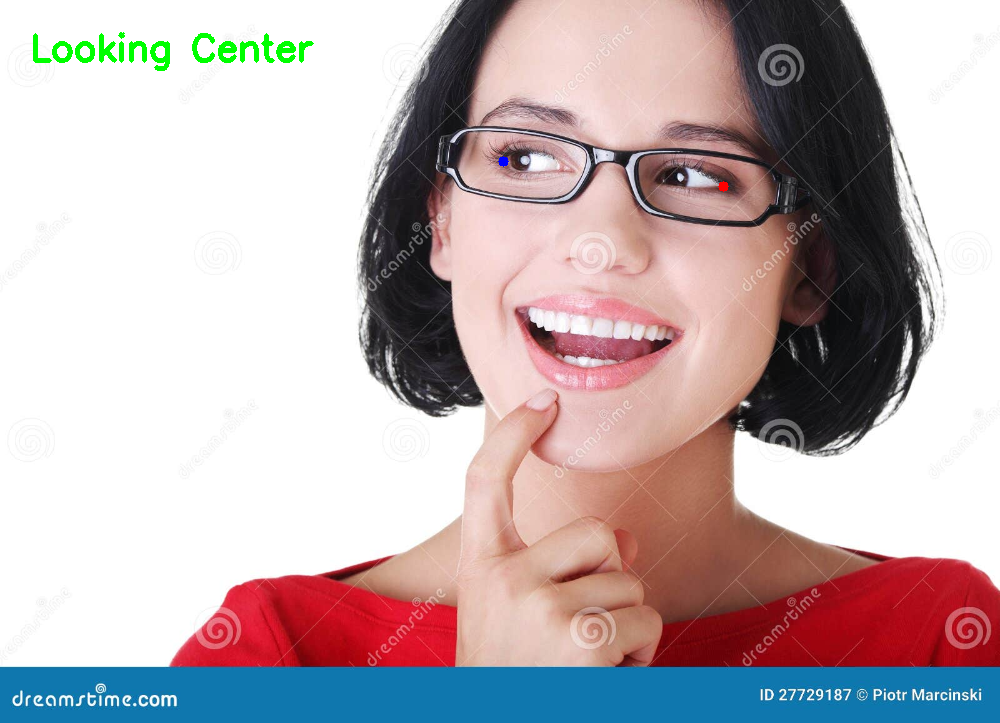

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow
from google.colab import files

# Upload image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
image = cv2.imread(image_path)

# Resize if the image is too large
if image.shape[1] > 1000:
    image = cv2.resize(image, (1000, int(image.shape[0] * 1000 / image.shape[1])))

# Constants for landmark indices
LEFT_EYE_IDX = 33
RIGHT_EYE_IDX = 263
NOSE_TIP_IDX = 1
CHIN_IDX = 152
LEFT_MOUTH_IDX = 61
RIGHT_MOUTH_IDX = 291

# Initialize MediaPipe face mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True)

# Process the uploaded image
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = face_mesh.process(rgb)

# Functions to extract landmarks and compute head pose
def get_landmark_coords(landmarks, shape):
    h, w, _ = shape  # Fix: unpack the image shape correctly (height, width, channels)
    return [(int(pt.x * w), int(pt.y * h)) for pt in landmarks]

def compute_head_pose(landmarks, shape):
    image_points = np.array([
        get_landmark_coords([landmarks[NOSE_TIP_IDX]], shape)[0],
        get_landmark_coords([landmarks[CHIN_IDX]], shape)[0],
        get_landmark_coords([landmarks[LEFT_EYE_IDX]], shape)[0],
        get_landmark_coords([landmarks[RIGHT_EYE_IDX]], shape)[0],
        get_landmark_coords([landmarks[LEFT_MOUTH_IDX]], shape)[0],
        get_landmark_coords([landmarks[RIGHT_MOUTH_IDX]], shape)[0],
    ], dtype="double")

    model_points = np.array([
        (0.0, 0.0, 0.0),       # Nose tip
        (0.0, -63.6, -12.5),   # Chin
        (-43.3, 32.7, -26),    # Left eye
        (43.3, 32.7, -26),     # Right eye
        (-28.9, -28.9, -24.1), # Left Mouth
        (28.9, -28.9, -24.1)   # Right mouth
    ])

    focal_length = shape[1]
    center = (shape[1] / 2, shape[0] / 2)
    camera_matrix = np.array([
        [focal_length, 0, center[0]],
        [0, focal_length, center[1]],
        [0, 0, 1]
    ], dtype="double")

    dist_coeffs = np.zeros((4, 1))  # Assuming no lens distortion

    success, rot_vec, trans_vec = cv2.solvePnP(
        model_points, image_points, camera_matrix, dist_coeffs
    )

    return rot_vec, trans_vec

def get_gaze_direction(left_eye, right_eye):
    eye_vector = np.array(right_eye) - np.array(left_eye)
    angle = np.arctan2(eye_vector[1], eye_vector[0]) * 180 / np.pi
    return angle

def classify_gaze(yaw, eye_angle):
    # Combining both yaw (head pose) and eye gaze angle
    if eye_angle < -10:
        gaze_label = "Looking Left"
    elif eye_angle > 10:
        gaze_label = "Looking Right"
    else:
        if yaw < -15:
            gaze_label = "Looking Left (Head)"
        elif yaw > 15:
            gaze_label = "Looking Right (Head)"
        else:
            gaze_label = "Looking Center"
    return gaze_label

# If a face is detected
if results.multi_face_landmarks:
    shape = image.shape
    landmarks = results.multi_face_landmarks[0].landmark

    # Get head pose (yaw)
    rot_vec, _ = compute_head_pose(landmarks, shape)
    rot_matrix, _ = cv2.Rodrigues(rot_vec)  # Correct unpacking
    angles, _, _, _, _, _ = cv2.RQDecomp3x3(rot_matrix)
    yaw = angles[1]  # Yaw angle

    # Get eye positions
    left_eye = get_landmark_coords([landmarks[LEFT_EYE_IDX]], shape)[0]
    right_eye = get_landmark_coords([landmarks[RIGHT_EYE_IDX]], shape)[0]

    # Estimate eye gaze direction
    eye_angle = get_gaze_direction(left_eye, right_eye)

    # Classify gaze
    gaze_label = classify_gaze(yaw, eye_angle)

    # Annotate the image with gaze label
    cv2.putText(image, gaze_label, (30, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 3)

    # Draw eye landmarks
    cv2.circle(image, left_eye, 5, (255, 0, 0), -1)
    cv2.circle(image, right_eye, 5, (0, 0, 255), -1)

    # Show the processed image in Colab
    cv2_imshow(image)
else:
    print("No face detected.")

## Eye Gaze Only

Saving looking left.jpg to looking left (2).jpg
Gaze Direction: Looking Right


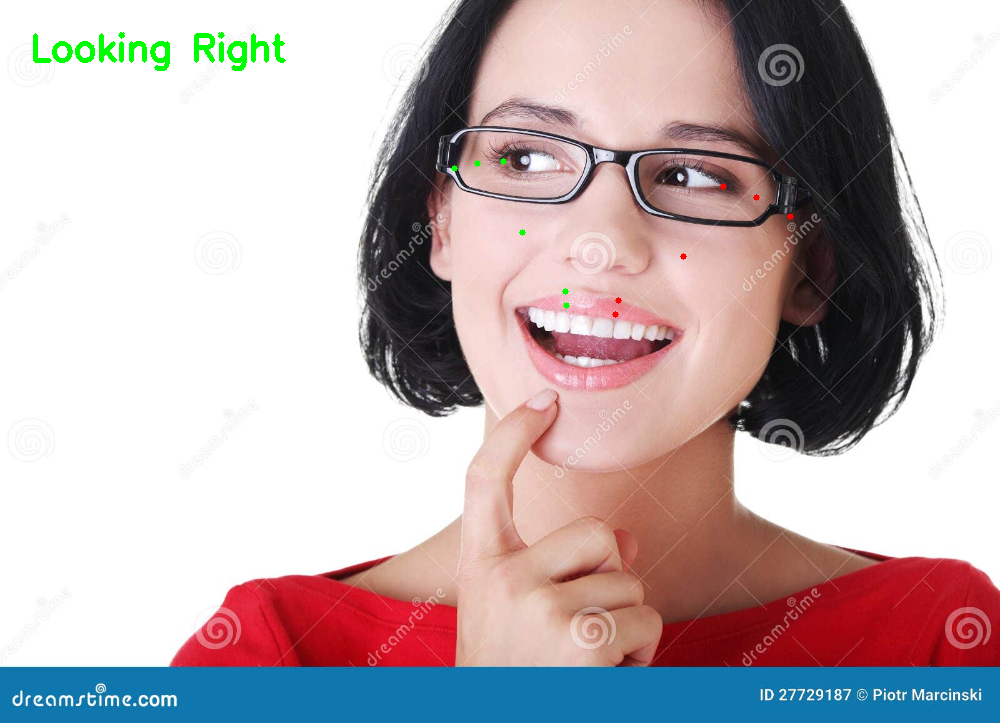

In [ ]:
# Install required dependencies
# !pip install opencv-python-headless==4.7.0.72 mediapipe --quiet

import cv2
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow
from google.colab import files

# Upload image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
image = cv2.imread(image_path)

# Resize if the image is too large
if image.shape[1] > 1000:
    image = cv2.resize(image, (1000, int(image.shape[0] * 1000 / image.shape[1])))

# Initialize MediaPipe face mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True)

# Constants for eye landmarks
LEFT_EYE_IDX = 33
RIGHT_EYE_IDX = 263

# Process the uploaded image
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = face_mesh.process(rgb)

# Function to get the eye landmarks coordinates
def get_eye_landmark_coords(landmarks, shape):
    h, w, _ = shape  # Fix: unpack the image shape correctly (height, width, channels)
    left_eye = [(int(pt.x * w), int(pt.y * h)) for pt in landmarks[LEFT_EYE_IDX:LEFT_EYE_IDX + 6]]
    right_eye = [(int(pt.x * w), int(pt.y * h)) for pt in landmarks[RIGHT_EYE_IDX:RIGHT_EYE_IDX + 6]]
    return left_eye, right_eye

# Function to determine gaze direction based on the eye landmarks
def determine_gaze_direction(left_eye, right_eye):
    # Average x positions of the left and right eye
    left_eye_x = np.mean([point[0] for point in left_eye])
    right_eye_x = np.mean([point[0] for point in right_eye])

    # Calculate the horizontal difference between the eyes
    horizontal_diff = right_eye_x - left_eye_x

    # Classify gaze direction
    if horizontal_diff > 20:  # Looking right
        return "Looking Right"
    elif horizontal_diff < -20:  # Looking left
        return "Looking Left"
    else:  # Looking center
        return "Looking Center"

# If a face is detected
if results.multi_face_landmarks:
    shape = image.shape
    landmarks = results.multi_face_landmarks[0].landmark

    # Get the eye landmarks for both left and right eyes
    left_eye, right_eye = get_eye_landmark_coords(landmarks, shape)

    # Determine gaze direction based on eye landmarks
    gaze_direction = determine_gaze_direction(left_eye, right_eye)

    # Print the gaze direction
    print(f"Gaze Direction: {gaze_direction}")

    # Draw circles on the eye landmarks
    for point in left_eye:
        cv2.circle(image, point, 3, (0, 255, 0), -1)  # Green for left eye landmarks
    for point in right_eye:
        cv2.circle(image, point, 3, (0, 0, 255), -1)  # Red for right eye landmarks

    # Annotate the image with gaze direction
    cv2.putText(image, gaze_direction, (30, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 3)

    # Show the processed image with tracked eye landmarks
    cv2_imshow(image)
else:
    print("No face detected.")


## Eye Gaze and Head Pose

In [1]:
# Install if not already
# !pip install opencv-python-headless==4.7.0.72 mediapipe --quiet

import cv2
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow
from google.colab import files

# Upload multiple images
uploaded = files.upload()
image_paths = list(uploaded.keys())

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True)

# Landmark indices
LEFT_EYE_IDX = 33
RIGHT_EYE_IDX = 263
NOSE_TIP_IDX = 1
CHIN_IDX = 152
LEFT_MOUTH_IDX = 61
RIGHT_MOUTH_IDX = 291

# Helper functions
def get_landmark_coords(landmarks, shape):
    h, w, _ = shape
    return [(int(pt.x * w), int(pt.y * h)) for pt in landmarks]

def compute_head_pose(landmarks, shape):
    image_points = np.array([
        get_landmark_coords([landmarks[NOSE_TIP_IDX]], shape)[0],
        get_landmark_coords([landmarks[CHIN_IDX]], shape)[0],
        get_landmark_coords([landmarks[LEFT_EYE_IDX]], shape)[0],
        get_landmark_coords([landmarks[RIGHT_EYE_IDX]], shape)[0],
        get_landmark_coords([landmarks[LEFT_MOUTH_IDX]], shape)[0],
        get_landmark_coords([landmarks[RIGHT_MOUTH_IDX]], shape)[0],
    ], dtype="double")

    model_points = np.array([
        (0.0, 0.0, 0.0),
        (0.0, -63.6, -12.5),
        (-43.3, 32.7, -26),
        (43.3, 32.7, -26),
        (-28.9, -28.9, -24.1),
        (28.9, -28.9, -24.1)
    ])

    focal_length = shape[1]
    center = (shape[1] / 2, shape[0] / 2)
    camera_matrix = np.array([
        [focal_length, 0, center[0]],
        [0, focal_length, center[1]],
        [0, 0, 1]
    ], dtype="double")

    dist_coeffs = np.zeros((4, 1))
    success, rot_vec, trans_vec = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs)
    return rot_vec, trans_vec

def get_gaze_direction(left_eye, right_eye):
    eye_vector = np.array(right_eye) - np.array(left_eye)
    angle = np.arctan2(eye_vector[1], eye_vector[0]) * 180 / np.pi
    return angle

def describe_gaze(yaw, eye_angle):
    head_dir = "Facing Center"
    eye_dir = "Looking Center"
    if yaw < -10: head_dir = "Facing Left"
    elif yaw > 10: head_dir = "Facing Right"
    if eye_angle < -10: eye_dir = "Looking Left"
    elif eye_angle > 10: eye_dir = "Looking Right"
    return f"{eye_dir} / {head_dir}"

def smart_attention_score(yaw, eye_angle):
    yaw_abs = abs(yaw)
    eye_abs = abs(eye_angle)
    same_dir = (yaw > 10 and eye_angle > 10) or (yaw < -10 and eye_angle < -10)
    opposite_dir = (yaw > 10 and eye_angle < -10) or (yaw < -10 and eye_angle > 10)

    if yaw_abs < 10 and eye_abs < 10:
        return 100
    elif yaw_abs < 10 and eye_abs < 20:
        return 75
    elif yaw_abs < 10:
        return 50
    elif opposite_dir:
        return 60
    elif same_dir:
        return 25
    else:
        return 50

# Process all images
for image_path in image_paths:
    print(f"\nProcessing: {image_path}")
    image = cv2.imread(image_path)
    if image.shape[1] > 1000:
        image = cv2.resize(image, (1000, int(image.shape[0] * 1000 / image.shape[1])))

    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if results.multi_face_landmarks:
        shape = image.shape
        landmarks = results.multi_face_landmarks[0].landmark

        # Head pose
        rot_vec, _ = compute_head_pose(landmarks, shape)
        rot_matrix, _ = cv2.Rodrigues(rot_vec)
        angles, _, _, _, _, _ = cv2.RQDecomp3x3(rot_matrix)
        yaw = angles[1]

        # Eyes
        left_eye = get_landmark_coords([landmarks[LEFT_EYE_IDX]], shape)[0]
        right_eye = get_landmark_coords([landmarks[RIGHT_EYE_IDX]], shape)[0]
        eye_angle = get_gaze_direction(left_eye, right_eye)

        # Output results
        gaze_label = describe_gaze(yaw, eye_angle)
        attention = smart_attention_score(yaw, eye_angle)

        # Display image only (no text on it)
        cv2_imshow(image)

        # Print the results below
        print(f"Gaze Direction: {gaze_label}")
        print(f"Attention Score: {attention}%")

    else:
        print("No face detected.")


ModuleNotFoundError: No module named 'google.colab'

## With Annotations on images

In [ ]:
# Install if not already
# !pip install opencv-python-headless==4.7.0.72 mediapipe --quiet

import cv2
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow
from google.colab import files

# Upload multiple images
uploaded = files.upload()
image_paths = list(uploaded.keys())

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True)

# Landmark indices
LEFT_EYE_IDX = 33
RIGHT_EYE_IDX = 263
NOSE_TIP_IDX = 1
CHIN_IDX = 152
LEFT_MOUTH_IDX = 61
RIGHT_MOUTH_IDX = 291

# Helper functions
def get_landmark_coords(landmarks, shape):
    h, w, _ = shape
    return [(int(pt.x * w), int(pt.y * h)) for pt in landmarks]

def compute_head_pose(landmarks, shape):
    image_points = np.array([
        get_landmark_coords([landmarks[NOSE_TIP_IDX]], shape)[0],
        get_landmark_coords([landmarks[CHIN_IDX]], shape)[0],
        get_landmark_coords([landmarks[LEFT_EYE_IDX]], shape)[0],
        get_landmark_coords([landmarks[RIGHT_EYE_IDX]], shape)[0],
        get_landmark_coords([landmarks[LEFT_MOUTH_IDX]], shape)[0],
        get_landmark_coords([landmarks[RIGHT_MOUTH_IDX]], shape)[0],
    ], dtype="double")

    model_points = np.array([
        (0.0, 0.0, 0.0),
        (0.0, -63.6, -12.5),
        (-43.3, 32.7, -26),
        (43.3, 32.7, -26),
        (-28.9, -28.9, -24.1),
        (28.9, -28.9, -24.1)
    ])

    focal_length = shape[1]
    center = (shape[1] / 2, shape[0] / 2)
    camera_matrix = np.array([
        [focal_length, 0, center[0]],
        [0, focal_length, center[1]],
        [0, 0, 1]
    ], dtype="double")

    dist_coeffs = np.zeros((4, 1))
    success, rot_vec, trans_vec = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs)
    return rot_vec, trans_vec

def get_gaze_direction(left_eye, right_eye):
    eye_vector = np.array(right_eye) - np.array(left_eye)
    angle = np.arctan2(eye_vector[1], eye_vector[0]) * 180 / np.pi
    return angle

def describe_gaze(yaw, eye_angle):
    head_dir = "Facing Center"
    eye_dir = "Looking Center"
    if yaw < -10: head_dir = "Facing Left"
    elif yaw > 10: head_dir = "Facing Right"
    if eye_angle < -10: eye_dir = "Looking Left"
    elif eye_angle > 10: eye_dir = "Looking Right"
    return f"{eye_dir} / {head_dir}"

def smart_attention_score(yaw, eye_angle):
    yaw_abs = abs(yaw)
    eye_abs = abs(eye_angle)
    same_dir = (yaw > 10 and eye_angle > 10) or (yaw < -10 and eye_angle < -10)
    opposite_dir = (yaw > 10 and eye_angle < -10) or (yaw < -10 and eye_angle > 10)

    if yaw_abs < 10 and eye_abs < 10:
        return 100
    elif yaw_abs < 10 and eye_abs < 20:
        return 75
    elif yaw_abs < 10:
        return 50
    elif opposite_dir:
        return 60
    elif same_dir:
        return 25
    else:
        return 50

# Process all images
for image_path in image_paths:
    print(f"Processing: {image_path}")
    image = cv2.imread(image_path)
    if image.shape[1] > 1000:
        image = cv2.resize(image, (1000, int(image.shape[0] * 1000 / image.shape[1])))

    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if results.multi_face_landmarks:
        shape = image.shape
        landmarks = results.multi_face_landmarks[0].landmark

        # Head pose
        rot_vec, _ = compute_head_pose(landmarks, shape)
        rot_matrix, _ = cv2.Rodrigues(rot_vec)
        angles, _, _, _, _, _ = cv2.RQDecomp3x3(rot_matrix)
        yaw = angles[1]

        # Eyes
        left_eye = get_landmark_coords([landmarks[LEFT_EYE_IDX]], shape)[0]
        right_eye = get_landmark_coords([landmarks[RIGHT_EYE_IDX]], shape)[0]
        eye_angle = get_gaze_direction(left_eye, right_eye)

        # Annotate
        gaze_label = describe_gaze(yaw, eye_angle)
        attention = smart_attention_score(yaw, eye_angle)

        cv2.putText(image, f"{gaze_label}", (30, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.putText(image, f"Attention: {attention}%", (30, 100),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

        cv2.circle(image, left_eye, 5, (255, 0, 0), -1)
        cv2.circle(image, right_eye, 5, (0, 0, 255), -1)

        # Display
        cv2_imshow(image)
    else:
        print("No face detected.")


## On Group Photos

Saving andSam.jpg to andSam (3).jpg
Saving billie_group_photo.jpg to billie_group_photo (3).jpg
Saving group.jpg to group (2).jpg

📸 Results for image: andSam (3).jpg

🧍 Face #1
   ➤ Looking Center / Facing Center
   ➤ Attention Score: 100%

🧍 Face #2
   ➤ Looking Center / Facing Right
   ➤ Attention Score: 50%

🧍 Face #3
   ➤ Looking Center / Facing Right
   ➤ Attention Score: 50%



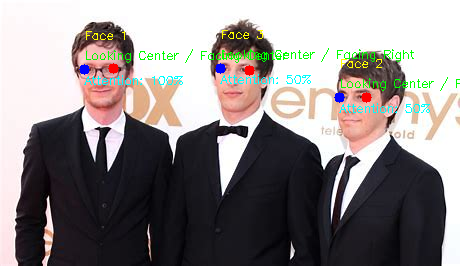


📸 Results for image: billie_group_photo (3).jpg

🧍 Face #1
   ➤ Looking Right / Facing Right
   ➤ Attention Score: 50%



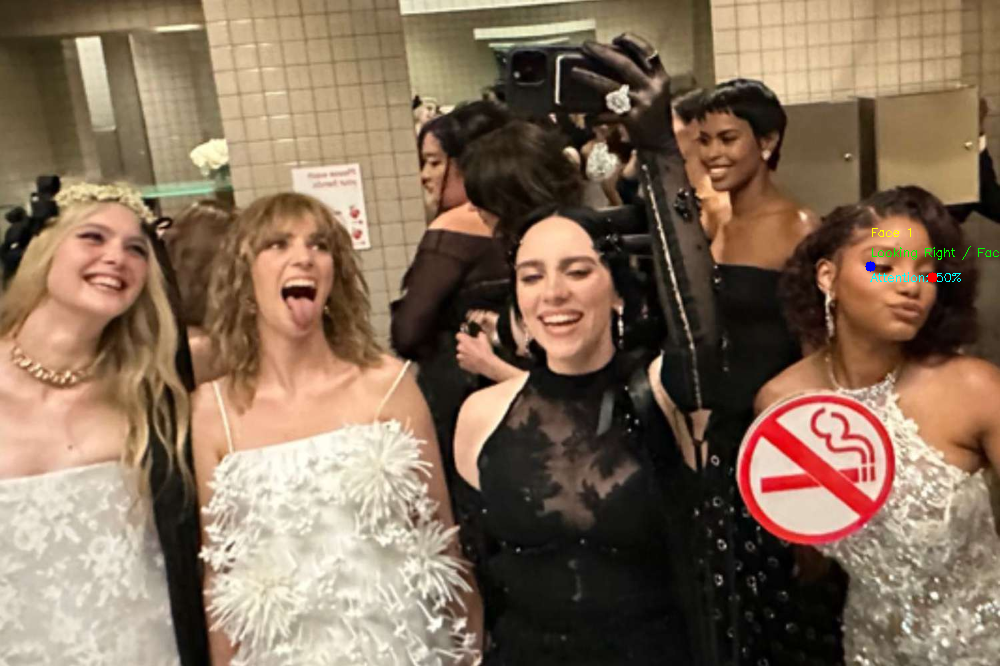


📸 Results for image: group (2).jpg

🧍 Face #1
   ➤ Looking Center / Facing Right
   ➤ Attention Score: 50%

🧍 Face #2
   ➤ Looking Center / Facing Right
   ➤ Attention Score: 50%

🧍 Face #3
   ➤ Looking Right / Facing Left
   ➤ Attention Score: 50%

🧍 Face #4
   ➤ Looking Center / Facing Left
   ➤ Attention Score: 50%

🧍 Face #5
   ➤ Looking Center / Facing Right
   ➤ Attention Score: 50%



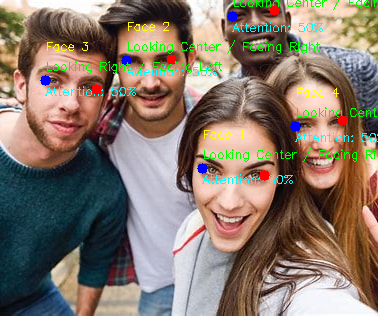

In [ ]:
# Install dependencies
# !pip install opencv-python-headless==4.7.0.72 mediapipe --quiet

import cv2
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow
from google.colab import files

# Upload image(s)
uploaded = files.upload()

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True, max_num_faces=10)

# Landmark indices
LEFT_EYE_IDX = 33
RIGHT_EYE_IDX = 263
NOSE_TIP_IDX = 1
CHIN_IDX = 152
LEFT_MOUTH_IDX = 61
RIGHT_MOUTH_IDX = 291

# Helper functions
def get_landmark_coords(landmarks, shape):
    h, w, _ = shape
    return [(int(pt.x * w), int(pt.y * h)) for pt in landmarks]

def compute_head_pose(landmarks, shape):
    image_points = np.array([
        get_landmark_coords([landmarks[NOSE_TIP_IDX]], shape)[0],
        get_landmark_coords([landmarks[CHIN_IDX]], shape)[0],
        get_landmark_coords([landmarks[LEFT_EYE_IDX]], shape)[0],
        get_landmark_coords([landmarks[RIGHT_EYE_IDX]], shape)[0],
        get_landmark_coords([landmarks[LEFT_MOUTH_IDX]], shape)[0],
        get_landmark_coords([landmarks[RIGHT_MOUTH_IDX]], shape)[0],
    ], dtype="double")

    model_points = np.array([
        (0.0, 0.0, 0.0),
        (0.0, -63.6, -12.5),
        (-43.3, 32.7, -26),
        (43.3, 32.7, -26),
        (-28.9, -28.9, -24.1),
        (28.9, -28.9, -24.1)
    ])

    focal_length = shape[1]
    center = (shape[1] / 2, shape[0] / 2)
    camera_matrix = np.array([
        [focal_length, 0, center[0]],
        [0, focal_length, center[1]],
        [0, 0, 1]
    ], dtype="double")

    dist_coeffs = np.zeros((4, 1))
    success, rot_vec, trans_vec = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs)
    return rot_vec, trans_vec

def get_gaze_direction(left_eye, right_eye):
    eye_vector = np.array(right_eye) - np.array(left_eye)
    angle = np.arctan2(eye_vector[1], eye_vector[0]) * 180 / np.pi
    return angle

def detailed_gaze_description(yaw, eye_angle):
    head = "Facing Center"
    eyes = "Looking Center"
    if yaw < -10: head = "Facing Left"
    elif yaw > 10: head = "Facing Right"
    if eye_angle < -10: eyes = "Looking Left"
    elif eye_angle > 10: eyes = "Looking Right"
    return f"{eyes} / {head}"

def calculate_attention_score(yaw, eye_angle):
    yaw_abs = abs(yaw)
    eye_abs = abs(eye_angle)
    if yaw_abs < 10 and eye_abs < 10:
        return 100
    elif yaw_abs < 10 and eye_abs < 20:
        return 75
    elif yaw_abs < 20 or eye_abs < 20:
        return 50
    else:
        return 25

# Process each uploaded image
for image_name in uploaded:
    image = cv2.imread(image_name)

    if image.shape[1] > 1000:
        image = cv2.resize(image, (1000, int(image.shape[0] * 1000 / image.shape[1])))

    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if results.multi_face_landmarks:
        shape = image.shape
        print(f"\n📸 Results for image: {image_name}\n")

        for i, face_landmarks in enumerate(results.multi_face_landmarks):
            landmarks = face_landmarks.landmark

            # Head pose
            rot_vec, _ = compute_head_pose(landmarks, shape)
            rot_matrix, _ = cv2.Rodrigues(rot_vec)
            angles, _, _, _, _, _ = cv2.RQDecomp3x3(rot_matrix)
            yaw = angles[1]

            # Eye positions
            left_eye = get_landmark_coords([landmarks[LEFT_EYE_IDX]], shape)[0]
            right_eye = get_landmark_coords([landmarks[RIGHT_EYE_IDX]], shape)[0]
            eye_angle = get_gaze_direction(left_eye, right_eye)

            # Label & score
            gaze_label = detailed_gaze_description(yaw, eye_angle)
            attention_score = calculate_attention_score(yaw, eye_angle)

            # Print conclusion
            print(f"🧍 Face #{i + 1}")
            print(f"   ➤ {gaze_label}")
            print(f"   ➤ Attention Score: {attention_score}%\n")

            # Draw landmarks and labels
            cv2.putText(image, f"Face {i+1}", (left_eye[0], left_eye[1] - 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 1)
            cv2.putText(image, gaze_label, (left_eye[0], left_eye[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)
            cv2.putText(image, f"Attention: {attention_score}%", (left_eye[0], left_eye[1] + 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)

            cv2.circle(image, left_eye, 5, (255, 0, 0), -1)
            cv2.circle(image, right_eye, 5, (0, 0, 255), -1)

        # Display the result
        cv2_imshow(image)
    else:
        print(f"No face detected in image: {image_name}")


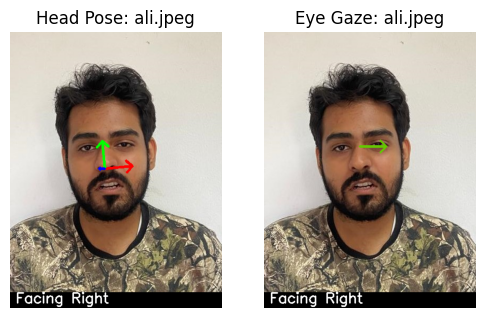

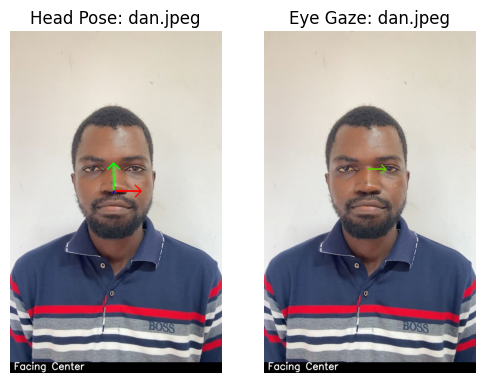

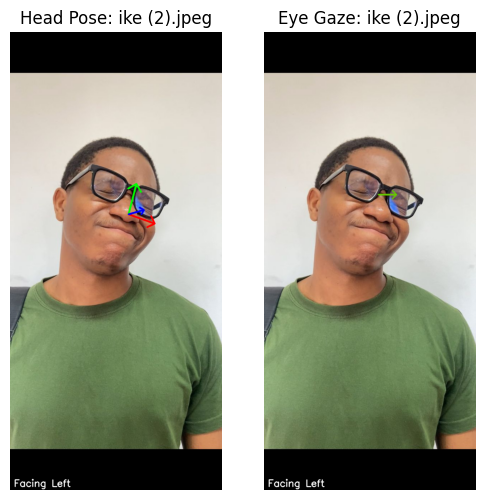

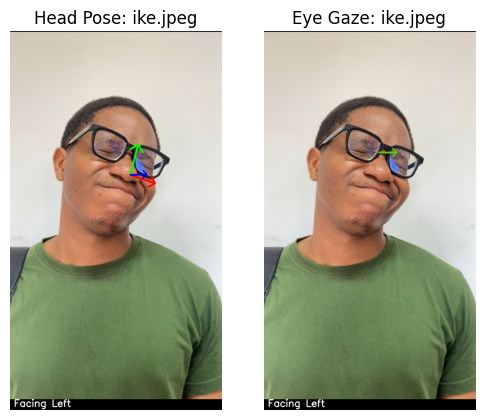

In [60]:
import os
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

# ---------------------------
# Setup
# ---------------------------
image_folder = "images"   # your images folder
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

mp_face_mesh = mp.solutions.face_mesh
mp_face_detection = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True)

# Landmark indices
LEFT_EYE_IDX = 33
RIGHT_EYE_IDX = 263
NOSE_TIP_IDX = 1
CHIN_IDX = 152
LEFT_MOUTH_IDX = 61
RIGHT_MOUTH_IDX = 291


# ---------------------------
# Functions
# ---------------------------
def compute_head_pose(landmarks, shape):
    h, w, _ = shape

    def get_coord(idx):
        return (int(landmarks[idx].x * w), int(landmarks[idx].y * h))

    image_points = np.array([
        get_coord(NOSE_TIP_IDX),
        get_coord(CHIN_IDX),
        get_coord(LEFT_EYE_IDX),
        get_coord(RIGHT_EYE_IDX),
        get_coord(LEFT_MOUTH_IDX),
        get_coord(RIGHT_MOUTH_IDX)
    ], dtype="double")

    model_points = np.array([
        (0.0, 0.0, 0.0),      # Nose tip
        (0.0, -63.6, -12.5),  # Chin
        (-43.3, 32.7, -26),   # Left eye
        (43.3, 32.7, -26),    # Right eye
        (-28.9, -28.9, -24.1),# Left mouth
        (28.9, -28.9, -24.1)  # Right mouth
    ])

    focal_length = w
    center = (w / 2, h / 2)
    camera_matrix = np.array([
        [focal_length, 0, center[0]],
        [0, focal_length, center[1]],
        [0, 0, 1]
    ], dtype="double")

    dist_coeffs = np.zeros((4, 1))
    _, rot_vec, trans_vec = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs)

    rot_matrix, _ = cv2.Rodrigues(rot_vec)
    angles, *_ = cv2.RQDecomp3x3(rot_matrix)

    return rot_vec, trans_vec, camera_matrix, dist_coeffs, angles


def draw_head_pose(image, rot_vec, trans_vec, camera_matrix, dist_coeffs):
    nose_end_points, _ = cv2.projectPoints(
        np.float32([[40,0,0],[0,40,0],[0,0,40]]),
        rot_vec, trans_vec, camera_matrix, dist_coeffs)

    nose_tip, _ = cv2.projectPoints(
        np.float32([[0,0,0]]), rot_vec, trans_vec, camera_matrix, dist_coeffs)

    p1 = tuple(nose_tip.reshape(2).astype(int))
    p2 = tuple(nose_end_points[0].ravel().astype(int))
    p3 = tuple(nose_end_points[1].ravel().astype(int))
    p4 = tuple(nose_end_points[2].ravel().astype(int))

    cv2.arrowedLine(image, p1, p2, (0,0,255), 3, tipLength=0.3)
    cv2.arrowedLine(image, p1, p3, (0,255,0), 3, tipLength=0.3)
    cv2.arrowedLine(image, p1, p4, (255,0,0), 3, tipLength=0.3)


def draw_eye_gaze(image, landmarks, shape):
    h, w, _ = shape
    left_eye = (int(landmarks[LEFT_EYE_IDX].x * w),
                int(landmarks[LEFT_EYE_IDX].y * h))
    right_eye = (int(landmarks[RIGHT_EYE_IDX].x * w),
                 int(landmarks[RIGHT_EYE_IDX].y * h))

    center = ((left_eye[0] + right_eye[0]) // 2,
              (left_eye[1] + right_eye[1]) // 2)

    gaze_end = (center[0] + 50, center[1])
    cv2.arrowedLine(image, center, gaze_end, (0,200,100), 3, tipLength=0.3)

    eye_vector = np.array(right_eye) - np.array(left_eye)
    eye_angle = np.degrees(np.arctan2(eye_vector[1], eye_vector[0]))
    return eye_angle


def smart_attention_score(yaw, eye_angle):
    yaw_abs = abs(yaw)
    eye_abs = abs(eye_angle)
    same_dir = (yaw > 10 and eye_angle > 10) or (yaw < -10 and eye_angle < -10)
    opposite_dir = (yaw > 10 and eye_angle < -10) or (yaw < -10 and eye_angle > 10)

    if yaw_abs < 10 and eye_abs < 10:
        return 100
    elif yaw_abs < 10 and eye_abs < 20:
        return 75
    elif yaw_abs < 10:
        return 50
    elif opposite_dir:
        return 60
    elif same_dir:
        return 25
    else:
        return 50


def process_image(image_path):
    image = cv2.imread(image_path)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if not results.multi_face_landmarks:
        return None, None

    landmarks = results.multi_face_landmarks[0].landmark
    shape = image.shape

    # ---- Head Pose ----
    head_img = image.copy()
    rot_vec, trans_vec, cam_matrix, dist_coeffs, angles = compute_head_pose(landmarks, shape)
    draw_head_pose(head_img, rot_vec, trans_vec, cam_matrix, dist_coeffs)
    yaw = angles[1] * 90

    # ---- Eye Gaze ----
    gaze_img = image.copy()
    eye_angle = draw_eye_gaze(gaze_img, landmarks, shape)

    # ---- Label text ----
    head_dir = "Facing Center"
    if yaw < -10: head_dir = "Facing Left"
    elif yaw > 10: head_dir = "Facing Right"

    eye_dir = "Looking Center"
    if eye_angle < -10: eye_dir = "Looking Left"
    elif eye_angle > 10: eye_dir = "Looking Right"

    attention = smart_attention_score(yaw, eye_angle)
    label = f"{head_dir}"

    for img in [head_img, gaze_img]:
        cv2.rectangle(img, (0, img.shape[0]-30),
                      (img.shape[1], img.shape[0]), (0,0,0), -1)
        cv2.putText(img, label, (10, img.shape[0]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)

    return head_img, gaze_img


# ---------------------------
# Run on all images
# ---------------------------
for img_path in image_paths:
    head_img, gaze_img = process_image(img_path)

    if head_img is None:
        print(f"No face detected in {os.path.basename(img_path)}")
        continue

    plt.figure(figsize=(6,6))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(head_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Head Pose: {os.path.basename(img_path)}")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(gaze_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Eye Gaze: {os.path.basename(img_path)}")
    plt.axis("off")

    plt.show()


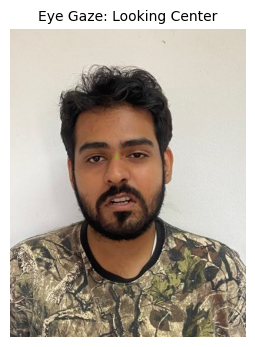

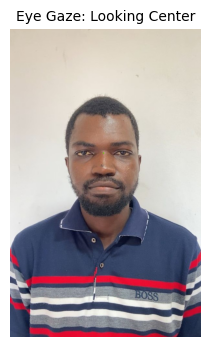

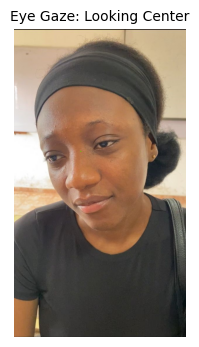

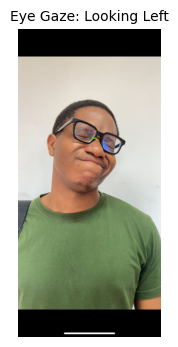

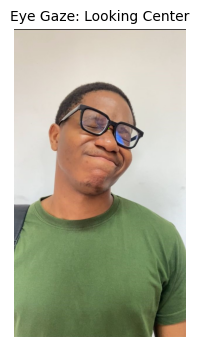

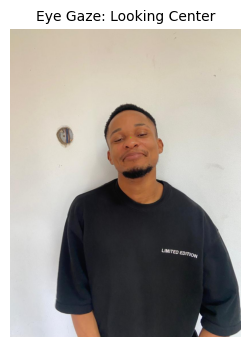

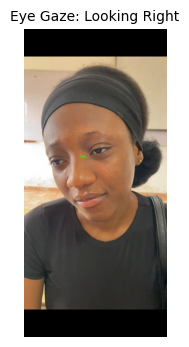

In [72]:
import os
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# Setup
# ---------------------------
image_folder = "images"
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True)

# Eye landmarks (for iris ratio)
LEFT_EYE_IDX = [33, 133, 159, 145]  # outer, inner, top, bottom
LEFT_IRIS_IDX = 468
RIGHT_EYE_IDX = [263, 362, 386, 374]
RIGHT_IRIS_IDX = 473

# ---------------------------
# Functions
# ---------------------------
def draw_eye_gaze(image, landmarks):
    h, w, _ = image.shape
    
    def iris_ratio(eye_idx, iris_idx):
        x_coords = [landmarks[i].x*w for i in eye_idx]
        y_coords = [landmarks[i].y*h for i in eye_idx]
        left, right = min(x_coords), max(x_coords)
        top, bottom = min(y_coords), max(y_coords)
        iris_x = landmarks[iris_idx].x*w
        iris_y = landmarks[iris_idx].y*h
        ratio_x = (iris_x - left) / (right - left + 1e-6)
        ratio_y = (iris_y - top) / (bottom - top + 1e-6)
        center = ((left+right)/2, (top+bottom)/2)
        size = max(right-left, bottom-top)/2
        return ratio_x, ratio_y, center, size

    left_ratio_x, left_ratio_y, left_center, left_size = iris_ratio(LEFT_EYE_IDX, LEFT_IRIS_IDX)
    right_ratio_x, right_ratio_y, right_center, right_size = iris_ratio(RIGHT_EYE_IDX, RIGHT_IRIS_IDX)
    
    avg_ratio_x = (left_ratio_x + right_ratio_x)/2
    avg_ratio_y = (left_ratio_y + right_ratio_y)/2
    eye_center = (int((left_center[0]+right_center[0])/2),
                  int((left_center[1]+right_center[1])/2))
    
    # Determine gaze
    if avg_ratio_x < 0.4:
        gaze_dir = "Looking Right"
        end_pt = (eye_center[0]+int(left_size*0.8), eye_center[1])
    elif avg_ratio_x > 0.6:
        gaze_dir = "Looking Left"
        end_pt = (eye_center[0]-int(left_size*0.8), eye_center[1])
    else:
        gaze_dir = "Looking Center"
        end_pt = eye_center

    cv2.arrowedLine(image, eye_center, end_pt, (0,200,100), 3, tipLength=0.3)
    return gaze_dir

# ---------------------------
# Run
# ---------------------------
for img_path in image_paths:
    image = cv2.imread(img_path)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)
    if not results.multi_face_landmarks:
        print(f"No face detected in {img_path}")
        continue

    landmarks = results.multi_face_landmarks[0].landmark
    gaze_img = image.copy()
    gaze_dir = draw_eye_gaze(gaze_img, landmarks)

    plt.figure(figsize=(4,4))
    plt.imshow(cv2.cvtColor(gaze_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Eye Gaze: {gaze_dir}",fontsize=10)
    plt.axis("off")
    plt.show()


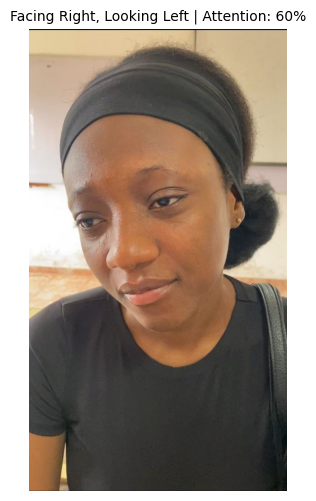

In [83]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True)

# Landmark indices
LEFT_EYE_IDX = 33
RIGHT_EYE_IDX = 263
NOSE_TIP_IDX = 1
CHIN_IDX = 152
LEFT_MOUTH_IDX = 61
RIGHT_MOUTH_IDX = 291

def compute_head_pose(landmarks, shape):
    h, w, _ = shape

    def get_coord(idx):
        return (int(landmarks[idx].x * w), int(landmarks[idx].y * h))

    image_points = np.array([
        get_coord(NOSE_TIP_IDX),
        get_coord(CHIN_IDX),
        get_coord(LEFT_EYE_IDX),
        get_coord(RIGHT_EYE_IDX),
        get_coord(LEFT_MOUTH_IDX),
        get_coord(RIGHT_MOUTH_IDX)
    ], dtype="double")

    model_points = np.array([
        (0.0, 0.0, 0.0),
        (0.0, -63.6, -12.5),
        (-43.3, 32.7, -26),
        (43.3, 32.7, -26),
        (-28.9, -28.9, -24.1),
        (28.9, -28.9, -24.1)
    ])

    focal_length = w
    center = (w / 2, h / 2)
    camera_matrix = np.array([
        [focal_length, 0, center[0]],
        [0, focal_length, center[1]],
        [0, 0, 1]
    ], dtype="double")

    dist_coeffs = np.zeros((4, 1))
    _, rot_vec, _ = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs)
    rot_matrix, _ = cv2.Rodrigues(rot_vec)
    angles, *_ = cv2.RQDecomp3x3(rot_matrix)
    return angles

def smart_attention_score(yaw, eye_angle):
    yaw_abs = abs(yaw)
    eye_abs = abs(eye_angle)
    same_dir = (yaw > 10 and eye_angle > 10) or (yaw < -10 and eye_angle < -10)
    opposite_dir = (yaw > 10 and eye_angle < -10) or (yaw < -10 and eye_angle > 10)

    if yaw_abs < 10 and eye_abs < 10:
        return 100
    elif yaw_abs < 10 and eye_abs < 20:
        return 75
    elif yaw_abs < 10:
        return 50
    elif opposite_dir:
        return 60
    elif same_dir:
        return 25
    else:
        return 50

def process_headpose(image_np, face_coordinates=None):
    """
    Compute attention score for a specific face.
    """
    if face_coordinates:
        top, right, bottom, left = face_coordinates
        image_np = image_np[top:bottom, left:right]  # crop to that face

    rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0].landmark
        h, w, _ = rgb.shape
        angles = compute_head_pose(landmarks, (h, w, 3))
        yaw = angles[1]

        left_eye = (int(landmarks[LEFT_EYE_IDX].x * w),
                    int(landmarks[LEFT_EYE_IDX].y * h))
        right_eye = (int(landmarks[RIGHT_EYE_IDX].x * w),
                     int(landmarks[RIGHT_EYE_IDX].y * h))
        eye_vector = np.array(right_eye) - np.array(left_eye)
        eye_angle = np.arctan2(eye_vector[1], eye_vector[0]) * 180 / np.pi

        score = smart_attention_score(yaw, eye_angle)

        # Determine simple labels
        if yaw < -10:
            head_label = "Facing Left"
        elif yaw > 10:
            head_label = "Facing Right"
        else:
            head_label = "Facing Center"

        if eye_angle < -10:
            eye_label = "Looking Left"
        elif eye_angle > 10:
            eye_label = "Looking Right"
        else:
            eye_label = "Looking Center"

        return {
            "head_label": head_label,
            "eye_label": eye_label,
            "attention_score": score,
            "image": image_np
        }

    return {"head_label": None, "eye_label": None, "attention_score": None, "image": image_np}

# ---------------------------
# Example usage
# ---------------------------
image_path = "images/eins.jpeg"  # Replace with your image
image_np = cv2.imread(image_path)
output = process_headpose(image_np)

# Display image with output text
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(output["image"], cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"{output['head_label']}, {output['eye_label']} | Attention: {output['attention_score']}%", fontsize=10)
plt.show()


# Engagement Score

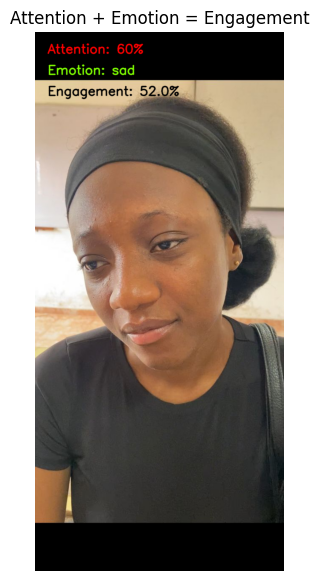

In [20]:
import cv2
import numpy as np
import mediapipe as mp
from deepface import DeepFace
from PIL import Image
import matplotlib.pyplot as plt

# -------------------------
# Emotion → Weight mapping
# -------------------------
EMOTION_WEIGHTS = {
    "happy": 1.0,
    "surprise": 0.9,
    "neutral": 0.7,
    "fear": 0.2,
    "sad": 0.4,
    "angry": 0.3,
    "disgust": 0.1
}

# -------------------------
# MediaPipe Face Mesh setup
# -------------------------
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True)

LEFT_EYE_IDX = 33
RIGHT_EYE_IDX = 263
NOSE_TIP_IDX = 1
CHIN_IDX = 152
LEFT_MOUTH_IDX = 61
RIGHT_MOUTH_IDX = 291

def compute_head_pose(landmarks, shape):
    h, w, _ = shape
    def get_coord(idx):
        return (int(landmarks[idx].x * w), int(landmarks[idx].y * h))

    image_points = np.array([
        get_coord(NOSE_TIP_IDX),
        get_coord(CHIN_IDX),
        get_coord(LEFT_EYE_IDX),
        get_coord(RIGHT_EYE_IDX),
        get_coord(LEFT_MOUTH_IDX),
        get_coord(RIGHT_MOUTH_IDX)
    ], dtype="double")

    model_points = np.array([
        (0.0, 0.0, 0.0),
        (0.0, -63.6, -12.5),
        (-43.3, 32.7, -26),
        (43.3, 32.7, -26),
        (-28.9, -28.9, -24.1),
        (28.9, -28.9, -24.1)
    ])

    focal_length = w
    center = (w / 2, h / 2)
    camera_matrix = np.array([
        [focal_length, 0, center[0]],
        [0, focal_length, center[1]],
        [0, 0, 1]
    ], dtype="double")

    dist_coeffs = np.zeros((4, 1))
    _, rot_vec, _ = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs)
    rot_matrix, _ = cv2.Rodrigues(rot_vec)
    angles, *_ = cv2.RQDecomp3x3(rot_matrix)
    return angles  # (pitch, yaw, roll)

def smart_attention_score(yaw, eye_angle):
    yaw_abs = abs(yaw)
    eye_abs = abs(eye_angle)
    same_dir = (yaw > 10 and eye_angle > 10) or (yaw < -10 and eye_angle < -10)
    opposite_dir = (yaw > 10 and eye_angle < -10) or (yaw < -10 and eye_angle > 10)

    if yaw_abs < 10 and eye_abs < 10:
        return 100
    elif yaw_abs < 10 and eye_abs < 20:
        return 75
    elif yaw_abs < 10:
        return 50
    elif opposite_dir:
        return 60
    elif same_dir:
        return 25
    else:
        return 50

def predict_emotion(pil_image):
    try:
        img_cv2 = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
        results = DeepFace.analyze(img_path=img_cv2, actions=['emotion'],
                                   detector_backend="opencv", enforce_detection=False)
        return results[0]["dominant_emotion"].lower()
    except Exception as e:
        print(f"[Emotion Prediction Error] {e}")
        return "neutral"

# -------------------------
# Main pipeline
# -------------------------
image_path = "eins.jpeg"  # replace with your image
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found: {image_path}")

rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = face_mesh.process(rgb)

if results.multi_face_landmarks:
    landmarks = results.multi_face_landmarks[0].landmark
    h, w, _ = image.shape
    angles = compute_head_pose(landmarks, (h, w, 3))
    yaw = angles[1]

    left_eye = (int(landmarks[LEFT_EYE_IDX].x * w), int(landmarks[LEFT_EYE_IDX].y * h))
    right_eye = (int(landmarks[RIGHT_EYE_IDX].x * w), int(landmarks[RIGHT_EYE_IDX].y * h))
    eye_vector = np.array(right_eye) - np.array(left_eye)
    eye_angle = np.arctan2(eye_vector[1], eye_vector[0]) * 180 / np.pi

    attention_score = smart_attention_score(yaw, eye_angle)

    # Emotion
    pil_image = Image.open(image_path).convert("RGB")
    emotion = predict_emotion(pil_image)
    emotion_weight = EMOTION_WEIGHTS.get(emotion, 0.5)

    # Engagement formula
    engagement = (attention_score * 0.6) + (emotion_weight * 100 * 0.4)

    # Overlay labels
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, f"Attention: {attention_score}%", (30, 50),
                font, 1.0, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(image, f"Emotion: {emotion}", (30, 100),
                font, 1.0, (0, 255, 128), 2, cv2.LINE_AA)
    cv2.putText(image, f"Engagement: {engagement:.1f}%", (30, 150),
                font, 1.0, (0, 0, 0), 2, cv2.LINE_AA)

    # Show result inline
    plt.figure(figsize=(7,7))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Attention + Emotion = Engagement")
    plt.show()
else:
    print("No face detected.")
